In [10]:
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [16]:
json_path = "via_project_14Apr2024_15h45m.json"


# JSONデータの読み込み
def load_annotations(json_path):
    with open(json_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    annotations = []
    for img_id, img_data in data["_via_img_metadata"].items():
        filename = img_data["filename"]
        for region in img_data["regions"]:
            shape_type = region["shape_attributes"]["name"]
            if shape_type == "rect":
                x = region["shape_attributes"]["x"]
                y = region["shape_attributes"]["y"]
                width = region["shape_attributes"]["width"]
                height = region["shape_attributes"]["height"]
                room_name = region["region_attributes"]["roomName"].strip()
                annotations.append(
                    {
                        "filename": filename,
                        "x": x,
                        "y": y,
                        "width": width,
                        "height": height,
                        "room_name": room_name,
                    }
                )
            elif shape_type == "polyline":
                all_points_x = region["shape_attributes"]["all_points_x"]
                all_points_y = region["shape_attributes"]["all_points_y"]
                x_min = min(all_points_x)
                x_max = max(all_points_x)
                y_min = min(all_points_y)
                y_max = max(all_points_y)
                width = x_max - x_min
                height = y_max - y_min
                room_name = region["region_attributes"]["roomName"].strip()
                annotations.append(
                    {
                        "filename": filename,
                        "x": x_min,
                        "y": y_min,
                        "width": width,
                        "height": height,
                        "room_name": room_name,
                    }
                )
    return annotations


# 画像とバウンディングボックスを表示する関数
def display_image_with_annotations(annotations, base_path):
    for ann in annotations:
        image_path = os.path.join(base_path, ann["filename"])
        image = cv2.imread(image_path)
        if image is not None:
            cv2.rectangle(
                image,
                (ann["x"], ann["y"]),
                (ann["x"] + ann["width"], ann["y"] + ann["height"]),
                (255, 0, 0),
                2,
            )
            cv2.putText(
                image,
                ann["room_name"],
                (ann["x"], ann["y"] - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 0, 0),
                2,
            )
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()

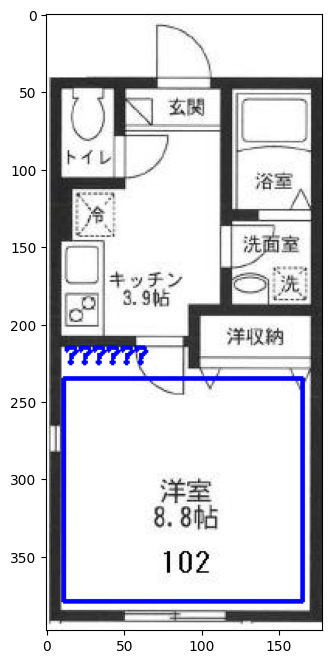

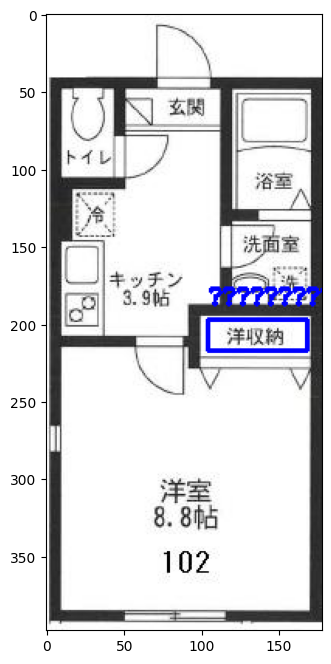

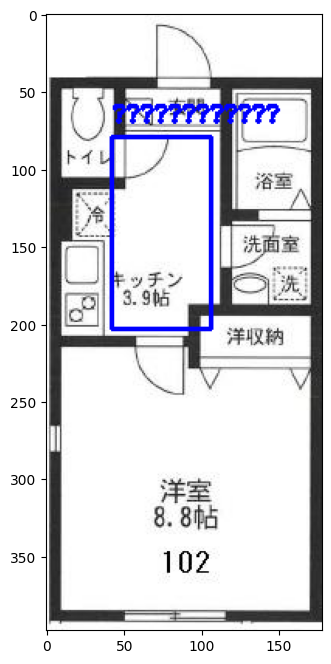

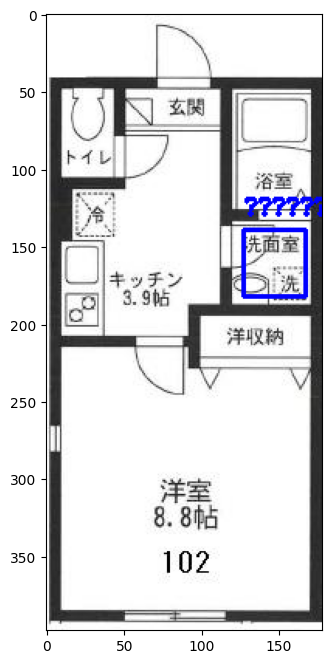

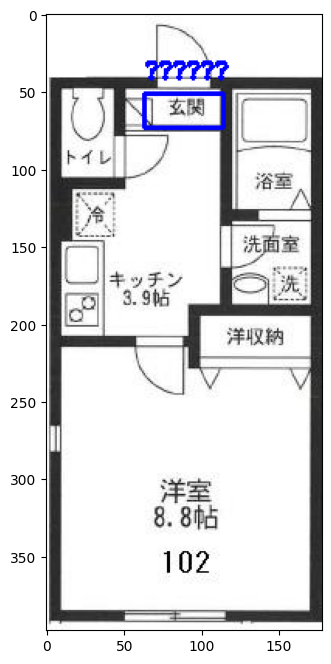

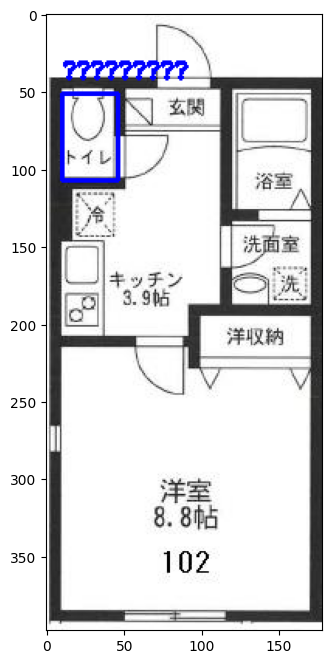

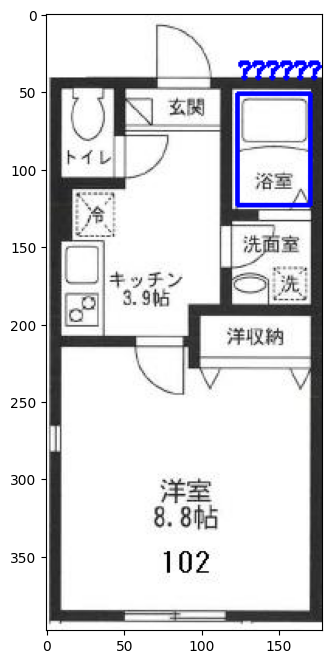

In [17]:
# アノテーションデータの読み込み
annotations = load_annotations(json_path)
display_image_with_annotations(annotations, "dataset/Set_A_02/gray")

In [31]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam


def extract_room_types(annotations):
    # すべての部屋の種類を抽出し、重複を排除する
    room_types = set(ann["room_name"] for ann in annotations)
    return sorted(list(room_types))  # ソートしてリストに変換


# `room_types` の生成
room_types = extract_room_types(annotations)
print("Room types:", room_types)

def create_model():
    model = Sequential(
        [
            Conv2D(
                32, (3, 3), activation="relu", input_shape=(128, 128, 3)
            ),  # 適宜入力サイズを調整
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(512, activation="relu"),
            Dropout(0.5),
            Dense(
                len(room_types), activation="softmax"
            ),  # room_typesは部屋の種類のリスト
        ]
    )
    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Room types: ['キッチン', 'トイレ', '洋収納', '洋室', '洗面室', '浴室', '玄関']


In [32]:
model = create_model()
model.summary()

/home/onikarubi/documents/team-shiny-products/floor-plan-ocr/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,942,407 (49.37 MB)

 Trainable params: 12,942,407 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np


# データとラベルの準備
def prepare_data(annotations, base_path):
    images = []
    labels = []
    for ann in annotations:
        image_path = os.path.join(base_path, ann["filename"])
        image = cv2.imread(image_path)
        if image is not None:
            cropped_image = image[
                ann["y"] : ann["y"] + ann["height"], ann["x"] : ann["x"] + ann["width"]
            ]
            resized_image = cv2.resize(
                cropped_image, (128, 128)
            )  # モデルの入力サイズに合わせてリサイズ
            images.append(resized_image)
            labels.append(
                room_types.index(ann["room_name"])
            )  # 部屋名をインデックスに変換

    # データをNumPy配列に変換
    images = np.array(images, dtype="float32") / 255.0  # 正規化
    labels = to_categorical(
        labels, num_classes=len(room_types)
    )  # ワンホットエンコーディング

    # データセットをトレーニングセットとテストセットに分割
    return train_test_split(images, labels, test_size=0.2, random_state=42)


# データの準備
x_train, x_test, y_train, y_test = prepare_data(annotations, "dataset/Set_A_02/gray")

# モデルのトレーニング
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 2.0460 - val_accuracy: 0.0000e+00 - val_loss: 4.6765
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4000 - loss: 1.3400 - val_accuracy: 0.0000e+00 - val_loss: 6.3136
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0000e+00 - loss: 2.2991 - val_accuracy: 0.0000e+00 - val_loss: 6.2446
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4000 - loss: 1.3379 - val_accuracy: 0.0000e+00 - val_loss: 5.3608
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.0000e+00 - loss: 2.3781 - val_accuracy: 0.0000e+00 - val_loss: 3.9881
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.0000e+00 - loss: 2.2829 - val_accuracy: 0.0000e+00 - val_loss: 2.7878
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2000 - loss: 1.7113 - val_accuracy: 0.0000e+00 - val_loss: 2.4883
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2000 - loss: 

In [35]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 3.5141
Test accuracy: 0.00%
